In [46]:
from functions import *

In [47]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
import rasterio
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pyproj
from geopandas.tools import sjoin
from shapely.geometry import Point
import requests
from scipy.stats import ks_2samp
import shutil

# Load data

In [89]:
W = 256
source_path = '../data/raw/'
data_paths = ['lst', 'ndvi', 'wt', 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
list_rgb = [True,False,False,False]

In [90]:
data, times = load_data(dir_paths,W,list_rgb)

/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


In [50]:
data_inputs = data[dir_paths[0]]
ndvi = data[dir_paths[1]]
data_targets = data[dir_paths[2]]
wt_stations = data[dir_paths[3]]
print('inputs shape:', data_inputs.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

inputs shape: (82, 256, 256, 3) (82, 256, 256)
targets shape: (82, 256, 256)


In [51]:
gdf_points = gpd.read_file('../data/external/wt_filtered.geojson')
time_slots = gdf_points.time.dt.strftime("%Y-%m").unique()
months = gdf_points.time.dt.month.unique()

In [52]:
time_slots

array(['2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08',
       '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02',
       '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08',
       '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02',
       '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
       '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
       '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
       '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
       '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
       '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
       '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
       '2019-09', '2019-10', '2019-11', '2019-12'],

# Delete unuseful data

In [53]:
'''new_inputs = []
new_targets = []
new_masked_inputs = []
del_indices = []
for index in range(0,data_inputs.shape[0]):
  img_gray = np.dot(data_inputs[index][...,:3], [0.2989, 0.5870, 0.1140])

  blacks = img_gray==0
  percentage_b = np.sum(blacks)/blacks.size * 100

  whites = img_gray>=240
  percentage_w = np.sum(whites)/whites.size * 100

  if not np.all(img_gray==255) and not np.all(img_gray==0) and not np.all(img_gray == img_gray[0,0]) and not (percentage_b > 50) and not (percentage_w > 50):
    new_inputs.append(data_inputs[index])
    new_targets.append(data_targets[index])
    new_masked_inputs.append(masked_inputs[index])
  else:
    del_indices.append(index)

new_inputs = np.array(new_inputs)
new_targets = np.array(new_targets)
new_masked_inputs = np.array(new_masked_inputs)
slots = np.delete(time_slots,del_indices)'''

'new_inputs = []\nnew_targets = []\nnew_masked_inputs = []\ndel_indices = []\nfor index in range(0,data_inputs.shape[0]):\n  img_gray = np.dot(data_inputs[index][...,:3], [0.2989, 0.5870, 0.1140])\n\n  blacks = img_gray==0\n  percentage_b = np.sum(blacks)/blacks.size * 100\n\n  whites = img_gray>=240\n  percentage_w = np.sum(whites)/whites.size * 100\n\n  if not np.all(img_gray==255) and not np.all(img_gray==0) and not np.all(img_gray == img_gray[0,0]) and not (percentage_b > 50) and not (percentage_w > 50):\n    new_inputs.append(data_inputs[index])\n    new_targets.append(data_targets[index])\n    new_masked_inputs.append(masked_inputs[index])\n  else:\n    del_indices.append(index)\n\nnew_inputs = np.array(new_inputs)\nnew_targets = np.array(new_targets)\nnew_masked_inputs = np.array(new_masked_inputs)\nslots = np.delete(time_slots,del_indices)'

Including NDVI data

In [54]:
del_indices = []
fixed_ndvi = []
for index in range(0,data_inputs.shape[0]):
  img_gray = np.dot(data_inputs[index][...,:3], [0.2989, 0.5870, 0.1140])

  blacks = img_gray==0
  percentage_b = np.sum(blacks)/blacks.size * 100

  whites = img_gray>=240
  percentage_w = np.sum(whites)/whites.size * 100

  img_ndvi = ndvi[index]

  whites = np.isnan(img_ndvi)
  percentage_w_ndvi = np.sum(whites)/whites.size * 100

  if np.all(img_gray == 255) or np.all(img_gray == 0) or np.all(img_gray == img_gray[0,0]) or (percentage_b > 50) or (percentage_w > 50) \
    or np.all(np.isnan(img_ndvi)) or np.all(img_ndvi == img_ndvi[0,0]) or (percentage_w_ndvi > 50):
    del_indices.append(index)
  else:
    new_ndvi = np.where(whites, 0.0, img_ndvi) # process ndvi images to not have nans
    fixed_ndvi.append(new_ndvi)


In [55]:
fixed_ndvi = np.array(fixed_ndvi)

In [56]:
slots = np.delete(time_slots,del_indices)

In [57]:
len(slots)

18

# Mask Landsat data

In [58]:
# Selecciona la imagen en el índice 0 (la primera imagen)
river_mask = data_targets[0]  # Cambia el índice según sea necesario

# Imprimir la forma de la imagen seleccionada
print('Selected image shape:', river_mask.shape)

Selected image shape: (256, 256)


In [59]:
# Supongamos que river_mask es tu máscara de río de forma (height, width)
# y que quieres que tenga 3 canales (para las imágenes RGB de data_inputs)
river_mask_expanded = np.expand_dims(river_mask, axis=-1)  # Expande para tener forma (height, width, 1)
river_mask_expanded = np.repeat(river_mask_expanded, data_inputs.shape[-1], axis=-1)  # Expande a (height, width, 3)

# Aplica la máscara solo a las entradas (inputs)
masked_inputs = []

for i,input_img in enumerate(data_inputs):
  if i not in del_indices:
    masked_input = input_img * river_mask_expanded  # Aplica la máscara a los inputs
    masked_inputs.append(masked_input)

# Convierte de nuevo a arrays de numpy
masked_inputs = np.array(masked_inputs)

# Verifica las formas
print('masked inputs shape:', masked_inputs.shape)

masked inputs shape: (18, 256, 256, 3)


# Mask NDVI data

In [60]:
masked_inputs_ndvi = []

for i,input_img in enumerate(fixed_ndvi):
    masked_input_ndvi = input_img * river_mask  # Aplica la máscara a los inputs
    masked_inputs_ndvi.append(masked_input_ndvi)

# Convierte de nuevo a arrays de numpy
masked_inputs_ndvi = np.array(masked_inputs_ndvi)

# Verifica las formas
print('masked inputs shape:', masked_inputs_ndvi.shape)

masked inputs shape: (18, 256, 256)


# Download preprocessed data

In [61]:
boiron = gpd.read_file('../data/external/swissTLMboiron')

bounds = boiron.total_bounds
# Definir la resolución
resolution = 30
x_min, y_min, x_max, y_max = bounds

transform = from_origin(x_min, y_max, resolution, resolution)  # Origen en la esquina superior izquierda

Clean preprocessed directories

In [64]:
raw_data_path = '../data/raw/'
preprocessed_data_path = '../data/preprocessed/'

data = ['wt', 'lst', 'ndvi', 'wt_interpolated','wt']#, 'lst/masked']
for d in data:
  dest_dir = os.path.join(preprocessed_data_path, d)
  os.makedirs(dest_dir, exist_ok=True)
  clear_directory(dest_dir)
  if d == 'lst':
    dest_dir_m = os.path.join(dest_dir, 'masked')
    os.makedirs(dest_dir_m, exist_ok=True)
    clear_directory(dest_dir_m)

Copy preprocessed images

In [65]:
for d in data:
  source_dir = os.path.join(raw_data_path, d)
  dest_dir = os.path.join(preprocessed_data_path, d)

  # List all files in the source directory
  all_images = os.listdir(source_dir)
  count = 0
  # Loop through each file and check if it contains any of the slots
  for ind, image_file in enumerate(all_images):
      # Check if the image filename contains any of the time slots
      if any(slot in image_file for slot in slots):
          # Construct full file paths
          if d == 'ndvi':
            date = image_file.split('_')[1].split('.')[0]
            name = f'{dest_dir}/ndvi_{date}.tiff'
            save_raster(fixed_ndvi[count], name, boiron)
            print(f'Copied: ndvi_{date}, at {dest_dir}')
          else:
            dst_path = os.path.join(dest_dir, image_file)
            src_path = os.path.join(source_dir, image_file)
            # Copy the file to the destination folder
            shutil.copy(src_path, dst_path)
            print()
            print('Image', count)
            print(f'Copied: {image_file}, from {src_path}, to {dst_path}')

            if d == 'lst':
              date = image_file.split('_')[1].split('.')[0]
              name = f'{dest_dir}/masked/lst_masked_{date}.tiff'
              save_raster(masked_inputs[count], name, boiron)
              print(f'Copied: lst_masked_{date}')

          count+=1





Image 0
Copied: raster_mask_temp_2018-10.tif, from ../data/raw/wt/raster_mask_temp_2018-10.tif, to ../data/preprocessed/wt/raster_mask_temp_2018-10.tif

Image 1
Copied: raster_mask_temp_2014-05.tif, from ../data/raw/wt/raster_mask_temp_2014-05.tif, to ../data/preprocessed/wt/raster_mask_temp_2014-05.tif

Image 2
Copied: raster_mask_temp_2014-11.tif, from ../data/raw/wt/raster_mask_temp_2014-11.tif, to ../data/preprocessed/wt/raster_mask_temp_2014-11.tif

Image 3
Copied: raster_mask_temp_2018-05.tif, from ../data/raw/wt/raster_mask_temp_2018-05.tif, to ../data/preprocessed/wt/raster_mask_temp_2018-05.tif

Image 4
Copied: raster_mask_temp_2016-05.tif, from ../data/raw/wt/raster_mask_temp_2016-05.tif, to ../data/preprocessed/wt/raster_mask_temp_2016-05.tif

Image 5
Copied: raster_mask_temp_2014-02.tif, from ../data/raw/wt/raster_mask_temp_2014-02.tif, to ../data/preprocessed/wt/raster_mask_temp_2014-02.tif

Image 6
Copied: raster_mask_temp_2014-03.tif, from ../data/raw/wt/raster_mask_tem

CHECK

In [66]:
dir_paths = ['../data/preprocessed/ndvi']
W = 256
list_rgb = [False]
data, time_slots = load_data(dir_paths,W,list_rgb)

(18, 256, 256)
0


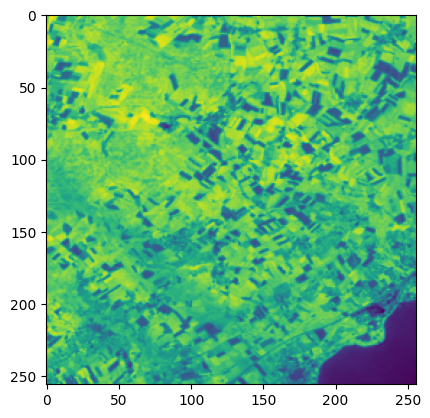

0


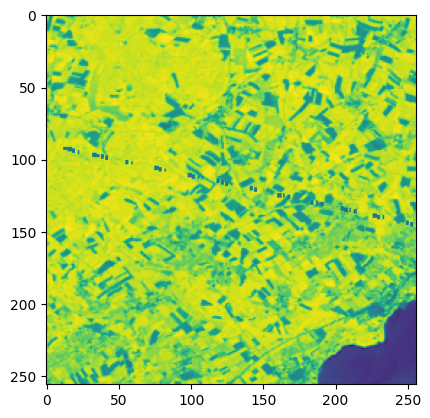

0


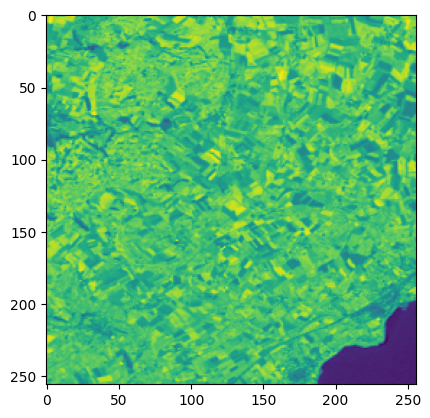

0


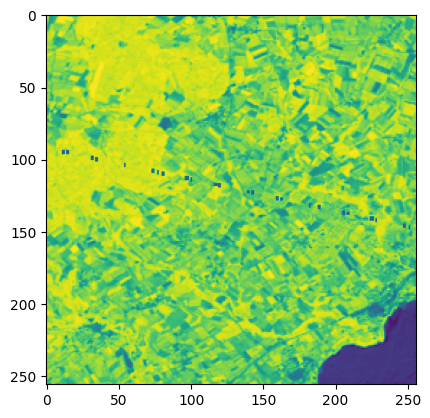

0


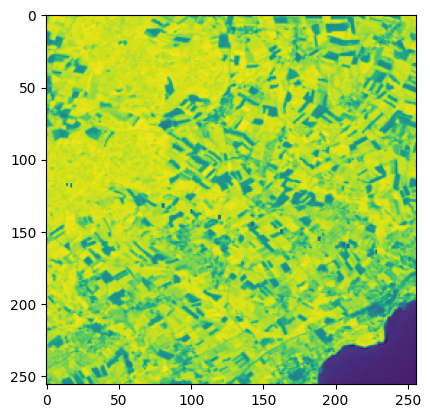

0


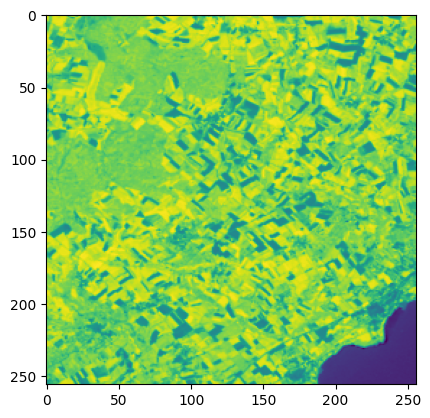

0


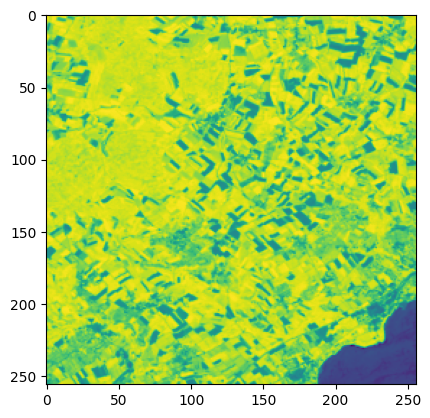

0


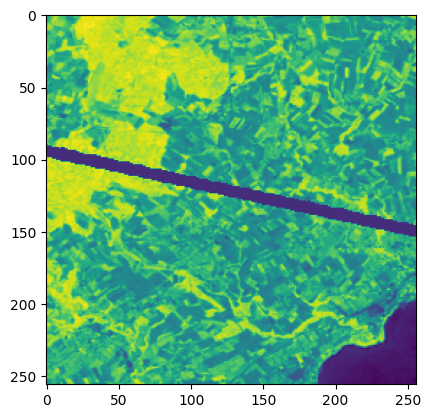

0


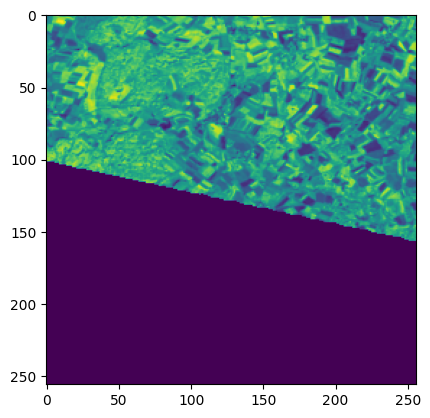

0


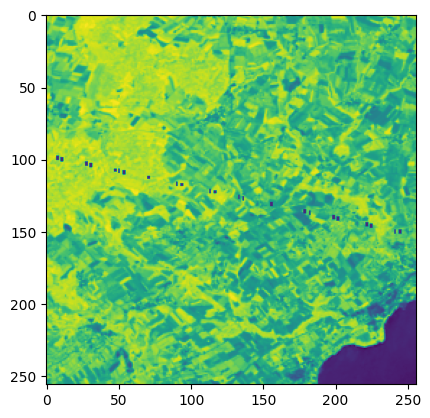

0


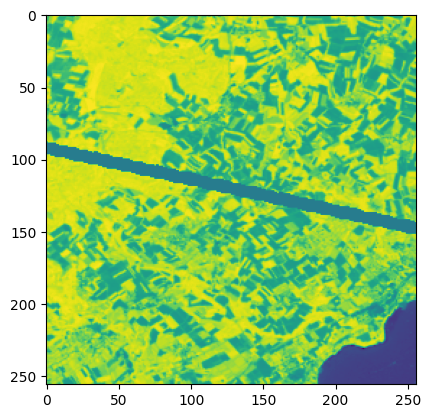

0


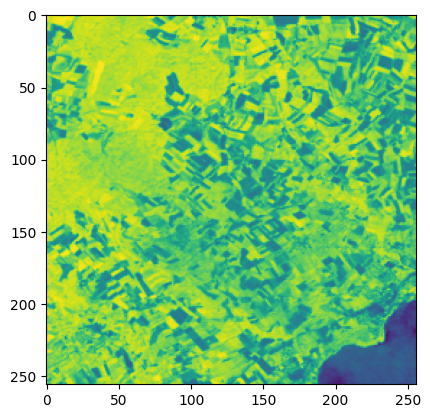

0


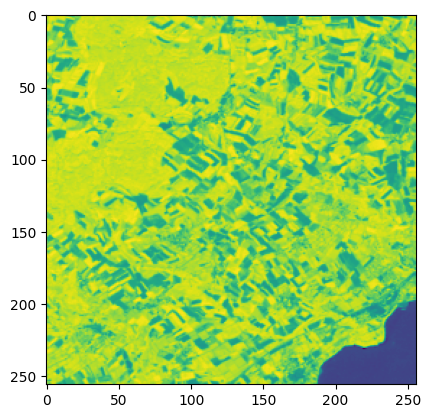

0


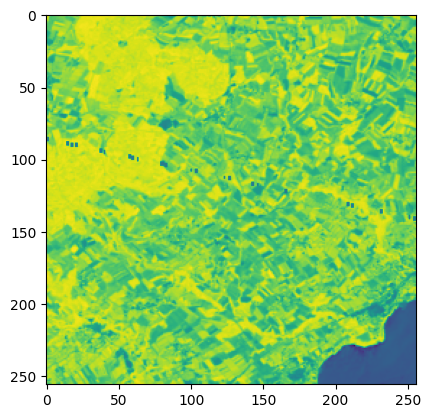

0


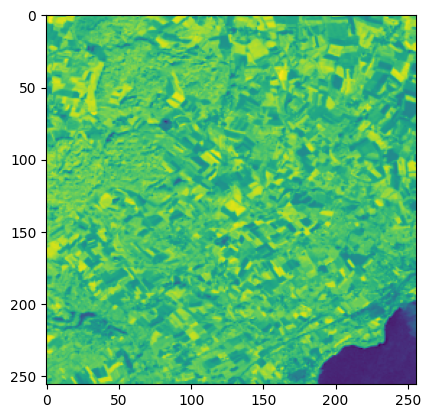

0


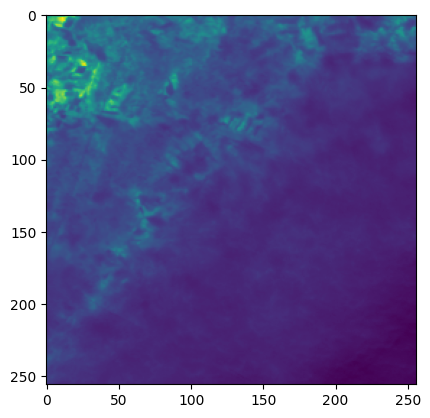

0


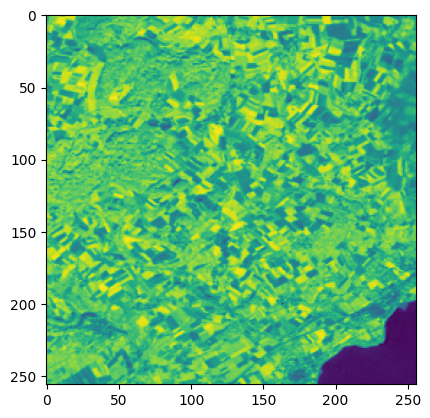

0


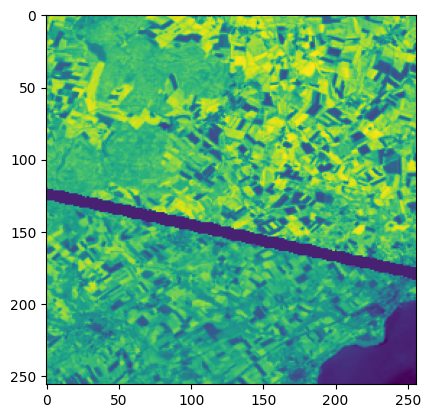

In [67]:
n = data[dir_paths[0]]
print(n.shape)
for i in n:
  print(np.sum(np.isnan(i)))
  plt.imshow(i)
  plt.show()

# Pixel wise dataset creation

In [68]:
river_indices = np.nonzero(river_mask.reshape(-1))[0]

In [69]:
len(river_indices)

4215

### LST dataset

In [70]:
pixel_ds_lst = pd.DataFrame(columns=[river_indices])
pixel_ds_lst

Empty DataFrame
Columns: [(29,), (30,), (31,), (285,), (286,), (287,), (541,), (542,), (797,), (798,), (1053,), (1054,), (1059,), (1060,), (1061,), (1070,), (1309,), (1310,), (1315,), (1316,), (1317,), (1326,), (1327,), (1564,), (1565,), (1566,), (1569,), (1570,), (1571,), (1572,), (1573,), (1582,), (1583,), (1820,), (1821,), (1822,), (1823,), (1824,), (1825,), (1826,), (1827,), (1828,), (1839,), (1840,), (2076,), (2077,), (2078,), (2079,), (2080,), (2081,), (2082,), (2095,), (2096,), (2097,), (2331,), (2332,), (2333,), (2334,), (2335,), (2336,), (2337,), (2351,), (2352,), (2353,), (2354,), (2356,), (2587,), (2588,), (2589,), (2590,), (2591,), (2592,), (2608,), (2609,), (2610,), (2612,), (2843,), (2844,), (2845,), (2846,), (2865,), (2866,), (2867,), (2868,), (3099,), (3100,), (3101,), (3102,), (3121,), (3122,), (3123,), (3124,), (3356,), (3357,), (3378,), (3379,), (3380,), (3393,), (3394,), (3395,), ...]
Index: []

[0 rows x 4215 columns]

In [71]:
for i,image in enumerate(masked_inputs):
  img_gray = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution

  flat_image = img_gray.flatten()

  river_image = flat_image[river_indices]
  pixel_ds_lst.loc[slots[i]] = river_image

In [72]:
pixel_ds_lst

29            30            31          285        286    \
2013-06   44.820137  3.474638e+01  1.999500e+01   43.272792  22.677235   
2014-02  152.437390  1.179726e+02  6.859190e+01  148.535579  77.992300   
2014-03  167.504722  1.301953e+02  7.566189e+01  164.347695  85.897067   
2014-05  160.455272  1.251327e+02  7.269553e+01  158.893073  83.340655   
2014-11  111.876399  8.794482e+01  5.192720e+01  108.812307  57.369260   
2015-03  117.999412  9.043950e+01  5.196139e+01  114.995363  60.081952   
2015-04  198.139223  1.503287e+02  8.732455e+01  189.164043  99.040280   
2015-07  195.083849  1.498069e+02  8.692717e+01  190.631640  99.385970   
2016-05  131.005483  9.997825e+01  5.765486e+01  125.301172  65.039883   
2016-08  122.583317  9.539133e+01  5.539461e+01  121.178414  63.730888   
2016-09  150.617696  1.170420e+02  6.798870e+01  147.358845  77.335186   
2017-01  124.805121  9.748800e+01  5.708736e+01  122.417578  63.801301   
2017-06  116.120438  9.144145e+01  5.371236e+01  114.954344  60.938945   
2017-07  170.110561  1.312972e+02  7.617344e+01  164.660259  86.363388   
2017-12  179.483088  1.382816e+02  8.026581e+01  174.819517  91.481199   
2018-05    0.122221  7.568057e-07  4.850071e-08    0.905185   0.350924   
2018-10  177.279357  1.379952e+02  7.990187e+01  173.476843  91.290407   
2019-02  107.515985  8.305062e+01  4.813005e+01  105.064545  54.848746   

                287        541         542         797        798    ...  \
2013-06  4.860956e-04   8.316766   33.083059   40.888065  13.700035  ...   
2014-02  1.670175e-03  29.326258  114.629449  143.953915  47.117052  ...   
2014-03  1.832747e-03  32.291158  125.179301  158.616514  51.722477  ...   
2014-05  1.777949e-03  31.516164  123.189274  155.418051  50.869338  ...   
2014-11  1.238054e-03  21.227072   82.971636  101.940576  33.365813  ...   
2015-03  1.283791e-03  22.662502   88.114553  112.075021  36.489145  ...   
2015-04  2.107777e-03  37.325571  145.431786  184.001241  60.224801  ...   
2015-07  2.108318e-03  37.643726  146.566322  185.433894  60.579065  ...   
2016-05  1.377344e-03  24.193256   94.097908  118.327564  38.614727  ...   
2016-08  1.366097e-03  23.955158   94.102919  118.467711  39.066150  ...   
2016-09  1.646610e-03  29.108680  113.778984  143.953912  47.214212  ...   
2017-01  1.363517e-03  23.974393   92.667649  117.044999  37.780669  ...   
2017-06  1.308719e-03  22.639417   88.963373  109.166807  36.083679  ...   
2017-07  1.838511e-03  32.172170  125.750707  158.374889  51.625317  ...   
2017-12  1.945746e-03  34.260919  133.450038  168.116133  54.910849  ...   
2018-05  8.227696e-07   0.220146    0.860497    2.606542   0.853139  ...   
2018-10  1.945746e-03  34.361373  134.310530  169.930556  55.619375  ...   
2019-02  1.178314e-03  20.672926   81.274071  102.582599  33.990218  ...   

              65207      65208     65209     65210         65461     65462  \
2013-06    7.997088   1.126881  0.000136  0.000020  6.051812e-05  0.000270   
2014-02  102.097381  18.634927  0.003593  0.003258  5.852072e-04  0.002973   
2014-03  138.248670  25.073299  0.004621  0.003851  7.791882e-04  0.003919   
2014-05  127.405115  23.356975  0.004474  0.003703  7.223984e-04  0.003665   
2014-11   59.091024  10.953667  0.002124  0.001839  3.249036e-04  0.001664   
2015-03   79.357445  14.734862  0.002879  0.002567  4.398460e-04  0.002239   
2015-04  216.506281  39.668616  0.007516  0.006199  1.208449e-03  0.006179   
2015-07  159.660007  28.919926  0.005326  0.004248  9.160205e-04  0.004562   
2016-05   60.887212  11.387754  0.002255  0.002047  3.402939e-04  0.001740   
2016-08   72.189636  13.594116  0.002723  0.002474  4.021115e-04  0.002052   
2016-09   93.019235  17.469865  0.003472  0.003189  5.133931e-04  0.002615   
2017-01   44.166129   8.124332  0.001583  0.001425  2.561205e-04  0.001289   
2017-06   66.218605  12.126265  0.002318  0.002020  3.780808e-04  0.001907   
2017-07   91.704601  17.219336  0.003414  0.003081  4.996786e-04  0.00

In [73]:
pixel_ds_lst.to_csv('../data/preprocessed/lst/leboiron_lst.csv')

### NDVI dataset

In [74]:
pixel_ds_ndvi = pd.DataFrame(columns=[river_indices])
pixel_ds_ndvi

Empty DataFrame
Columns: [(29,), (30,), (31,), (285,), (286,), (287,), (541,), (542,), (797,), (798,), (1053,), (1054,), (1059,), (1060,), (1061,), (1070,), (1309,), (1310,), (1315,), (1316,), (1317,), (1326,), (1327,), (1564,), (1565,), (1566,), (1569,), (1570,), (1571,), (1572,), (1573,), (1582,), (1583,), (1820,), (1821,), (1822,), (1823,), (1824,), (1825,), (1826,), (1827,), (1828,), (1839,), (1840,), (2076,), (2077,), (2078,), (2079,), (2080,), (2081,), (2082,), (2095,), (2096,), (2097,), (2331,), (2332,), (2333,), (2334,), (2335,), (2336,), (2337,), (2351,), (2352,), (2353,), (2354,), (2356,), (2587,), (2588,), (2589,), (2590,), (2591,), (2592,), (2608,), (2609,), (2610,), (2612,), (2843,), (2844,), (2845,), (2846,), (2865,), (2866,), (2867,), (2868,), (3099,), (3100,), (3101,), (3102,), (3121,), (3122,), (3123,), (3124,), (3356,), (3357,), (3378,), (3379,), (3380,), (3393,), (3394,), (3395,), ...]
Index: []

[0 rows x 4215 columns]

In [75]:
for i,image in enumerate(masked_inputs_ndvi):
  flat_image = image.flatten()
  river_image = flat_image[river_indices]

  #print(flat_image.shape, river_image.shape)

  pixel_ds_ndvi.loc[slots[i]] = river_image

In [76]:
pixel_ds_ndvi

29        30        31        285       286       287       541    \
2013-06  3.070348  2.400716  1.368999  3.036241  1.612980  0.000034  0.610174   
2014-02  2.874035  2.250957  1.316337  2.796869  1.500821  0.000033  0.521797   
2014-03  1.512196  1.056889  0.616858  1.431998  0.681033  0.000016  0.262795   
2014-05  2.844846  2.217233  1.269899  2.813739  1.481478  0.000032  0.569377   
2014-11  1.462434  1.089092  0.618563  1.192850  0.677105  0.000015  0.149973   
2015-03  1.860646  1.446407  0.829133  1.647413  0.906044  0.000021  0.294348   
2015-04  1.417046  1.080820  0.588284  1.322303  0.691504  0.000015  0.241505   
2015-07  1.580967  1.200118  0.621869  1.408956  0.726234  0.000014  0.261520   
2016-05  2.964965  2.309175  1.350207  2.918795  1.553280  0.000034  0.530345   
2016-08  2.218872  1.740659  1.017842  2.201709  1.176156  0.000026  0.393828   
2016-09  3.132384  2.444702  1.397539  3.099590  1.645352  0.000035  0.614589   
2017-01  3.114865  2.442450  1.402244  3.070680  1.628825  0.000035  0.613479   
2017-06  2.872568  2.211791  1.293077  2.776630  1.472011  0.000032  0.553072   
2017-07  1.707158  1.375265  0.793581  1.544575  0.894868  0.000020  0.252993   
2017-12  2.997407  2.304375  1.320548  2.901517  1.513069  0.000032  0.581320   
2018-05  2.985826  2.361904  1.362777  2.958487  1.588378  0.000034  0.561572   
2018-10  0.644008  0.488553  0.272622  0.577499  0.300183  0.000006  0.110814   
2019-02  2.921997  2.299124  1.285216  2.902360  1.533371  0.000033  0.583780   

            542       797       798    ...     65207     65208     65209  \
2013-06  2.361099  3.022061  0.987311  ...  1.164302  0.207103  0.000045   
2014-02  2.161129  2.599850  0.907875  ...  1.035731  0.233819  0.000051   
2014-03  0.975860  1.084581  0.405110  ...  0.698266  0.179203  0.000033   
2014-05  2.191454  2.771178  0.907760  ...  0.972182  0.208851  0.000044   
2014-11  0.796778  0.936870  0.337192  ...  0.722835  0.156976  0.000034   
2015-03  1.166754  1.570211  0.549844  ...  0.942774  0.209628  0.000044   
2015-04  1.035075  1.199933  0.404808  ...  0.000000  0.000000  0.000000   
2015-07  1.029269  1.137720  0.406056  ...  0.751661  0.160493  0.000035   
2016-05  2.250973  2.804795  0.933394  ...  1.062046  0.231018  0.000051   
2016-08  1.666065  2.098053  0.705502  ...  0.784184  0.174532  0.000036   
2016-09  2.407222  3.052440  0.996413  ...  1.058800  0.237141  0.000050   
2017-01  2.400786  3.040103  0.991087  ...  1.104739  0.215981  0.000043   
2017-06  2.188446  2.698083  0.880670  ...  1.078516  0.230685  0.000048   
2017-07  1.250089  1.458497  0.506868  ...  0.795114  0.174875  0.000036   
2017-12  2.225673  2.829115  0.922152  ...  0.998374  0.180228  0.000036   
2018-05  2.321923  2.912458  0.960058  ...  1.130571  0.225859  0.000050   
2018-10  0.431825  0.545559  0.184055  ...  0.099606  0.019104  0.000004   
2019-02  2.259754  2.876270  0.936732  ...  0.891032  0.157632  0.000033   

            65210         65461     65462     65463     65464     65465  \
2013-06  0.000041  6.836623e-06  0.000035  0.292493  1.123564  1.317990   
2014-02  0.000047  7.042463e-06  0.000036  0.301200  1.295882  1.507501   
2014-03  0.000024  5.278963e-06  0.000026  0.195527  0.941449  1.034388   
2014-05  0.000038  6.278558e-06  0.000034  0.277131  1.075387  1.109535   
2014-11  0.000025  4.705914e-06  0.000024  0.197633  0.911753  0.931648   
2015-03  0.000042  6.712860e-06  0.000034  0.287460  1.150945  1.202159   
2015-04  0.000000  0.000000e+00  0.000000  0.000000  0.000000  0.000000   
2015-07  0.000025  5.038267e-06  0.000026  0.217180  0.883721  1.079907   
2016-05  0.000049  7.111617e-06  0.000037  0.304732  1.175372  1.324590   
2016-08  0.000032  4.486884e-06  0.000023  0.187295  0.913995  0.994134   
2016-09  0.000046  7.136496e-06  0.000037  0.301256  1.214853  1.319687   
2017-01  0.000044  6.595279e-06  0.000034  0.301992  1.187645  1.262490   
2017-06  0.000043  6.828730e-06  0.000035  0.262716 

In [77]:
pixel_ds_ndvi.to_csv('../data/preprocessed/ndvi/leboiron_ndvi.csv')

### Water temperature dataset

In [78]:
pixel_ds_wt = pd.DataFrame(columns=[river_indices])
pixel_ds_wt

Empty DataFrame
Columns: [(29,), (30,), (31,), (285,), (286,), (287,), (541,), (542,), (797,), (798,), (1053,), (1054,), (1059,), (1060,), (1061,), (1070,), (1309,), (1310,), (1315,), (1316,), (1317,), (1326,), (1327,), (1564,), (1565,), (1566,), (1569,), (1570,), (1571,), (1572,), (1573,), (1582,), (1583,), (1820,), (1821,), (1822,), (1823,), (1824,), (1825,), (1826,), (1827,), (1828,), (1839,), (1840,), (2076,), (2077,), (2078,), (2079,), (2080,), (2081,), (2082,), (2095,), (2096,), (2097,), (2331,), (2332,), (2333,), (2334,), (2335,), (2336,), (2337,), (2351,), (2352,), (2353,), (2354,), (2356,), (2587,), (2588,), (2589,), (2590,), (2591,), (2592,), (2608,), (2609,), (2610,), (2612,), (2843,), (2844,), (2845,), (2846,), (2865,), (2866,), (2867,), (2868,), (3099,), (3100,), (3101,), (3102,), (3121,), (3122,), (3123,), (3124,), (3356,), (3357,), (3378,), (3379,), (3380,), (3393,), (3394,), (3395,), ...]
Index: []

[0 rows x 4215 columns]

In [79]:
c = 0
for i in range(len(data_targets)):
  if i not in del_indices:
    image = data_targets[i]
    flat_image = image.flatten()
    river_image = flat_image[river_indices]
    pixel_ds_wt.loc[slots[c]] = river_image
    c += 1

In [80]:
pixel_ds_wt

29         30         31         285        286       287    \
2013-06  16.741087  13.156702   7.708904  16.628387   8.762603  0.000188   
2014-02   4.671031   3.670930   2.150907   4.639585   2.444906  0.000052   
2014-03   8.351576   6.563444   3.845718   8.295354   4.371374  0.000094   
2014-05  13.850665  10.885139   6.377928  13.757424   7.249702  0.000155   
2014-11   7.708155   6.057784   3.549437   7.656265   4.034595  0.000086   
2015-03   6.961487   5.470984   3.205612   6.914623   3.643775  0.000078   
2015-04  11.558227   9.083529   5.322310  11.480418   6.049796  0.000130   
2015-07  22.873867  17.976410  10.532915  22.719883  11.972617  0.000257   
2016-05  13.412209  10.540560   6.176029  13.321919   7.020205  0.000150   
2016-08  20.046181  15.754150   9.230827  19.911232  10.492553  0.000225   
2016-09  18.182919  14.289826   8.372836  18.060514   9.517286  0.000204   
2017-01   0.291598   0.229165   0.134274   0.289635   0.152628  0.000003   
2017-06  20.400850  16.032883   9.394145  20.263515  10.678194  0.000229   
2017-07  20.381960  16.018038   9.385447  20.244751  10.668305  0.000229   
2017-12   1.520839   1.195216   0.700313   1.510600   0.796036  0.000017   
2018-05  15.325502  12.044204   7.057058  15.222332   8.021659  0.000172   
2018-10  12.000527   9.431129   5.525980  11.919742   6.281305  0.000135   
2019-02   4.585231   3.603501   2.111398   4.554364   2.399997  0.000051   

            541        542        797       798    ...      65207     65208  \
2013-06  3.298212  12.891935  16.310959  5.338683  ...   8.266809  1.575402   
2014-02  0.920254   3.597056   4.551018  1.489578  ...   2.306572  0.439562   
2014-03  1.645369   6.431361   8.136999  2.663293  ...   4.124038  0.785916   
2014-05  2.728761  10.666086  13.494801  4.416936  ...   6.839509  1.303402   
2014-11  1.518607   5.935877   7.510110  2.458108  ...   3.806314  0.725368   
2015-03  1.371503   5.360885   6.782626  2.219998  ...   3.437608  0.655103   
2015-04  2.277121   8.900731  11.261262  3.685884  ...   5.707494  1.087674   
2015-07  4.506449  17.614651  22.286169  7.294409  ...  11.295197  2.152520   
2016-05  2.642380  10.328441  13.067609  4.277114  ...   6.622997  1.262141   
2016-08  3.949358  15.437114  19.531136  6.392668  ...   9.898875  1.886424   
2016-09  3.582272  14.002257  17.715746  5.798479  ...   8.978790  1.711084   
2017-01  0.057449   0.224553   0.284106  0.092990  ...   0.143992  0.027440   
2017-06  4.019233  15.710237  19.876692  6.505771  ...  10.074013  1.919800   
2017-07  4.015511  15.695690  19.858288  6.499747  ...  10.064685  1.918022   
2017-12  0.299625   1.171164   1.481764  0.484991  ...   0.750996  0.143117   
2018-05  3.019323  11.801825  14.931745  4.887257  ...   7.567788  1.442190   
2018-10  2.364260   9.241337  11.692199  3.826933  ...   5.925904  1.129297   
2019-02  0.903350   3.530984   4.467423  1.462217  ...   2.264204  0.431488   

            65209     65210         65461     65462     65463      65464  \
2013-06  0.000321  0.000303  4.428510e-05  0.000227  2.078414  10.467926   
2014-02  0.000089  0.000085  1.235625e-05  0.000063  0.579911   2.920719   
2014-03  0.000160  0.000151  2.209237e-05  0.000113  1.036852   5.222103   
2014-05  0.000265  0.000251  3.663908e-05  0.000188  1.719567   8.660593   
2014-11  0.000148  0.000140  2.039034e-05  0.000104  0.956971   4.819782   
2015-03  0.000133  0.000126  1.841518e-05  0.000094  0.864272   4.352903   
2015-04  0.000221  0.000209  3.057491e-05  0.000157  1.434959   7.227169   
2015-07  0.000438  0.000414  6.050810e-05  0.000310  2.839801  14.302652   
2016-05  0.000257  0.000243  3.547924e-05  0.000182  1.665132   8.386434   
2016-08  0.000384  0.000363  5.302804e-05  0.000272  2.488743  12.534546   
2016-09  0.000348  0.000329  4.809917e-05  0.000246  2.257418  11.369480   
2017-01  0.000006  0.000005  7.713620e-07  0.000004  0.036202   0.182331   
2017-06  0.000391  0.000369  5.396625e-05  0.000276  2.532775  12.756315   
20

In [81]:
pixel_ds_wt.to_csv('../data/preprocessed/wt/leboiron_wt.csv')

### Water temperature stations dataset

In [97]:
pixel_ds_wt = pd.DataFrame(columns=[river_indices])
pixel_ds_wt

Empty DataFrame
Columns: [(29,), (30,), (31,), (285,), (286,), (287,), (541,), (542,), (797,), (798,), (1053,), (1054,), (1059,), (1060,), (1061,), (1070,), (1309,), (1310,), (1315,), (1316,), (1317,), (1326,), (1327,), (1564,), (1565,), (1566,), (1569,), (1570,), (1571,), (1572,), (1573,), (1582,), (1583,), (1820,), (1821,), (1822,), (1823,), (1824,), (1825,), (1826,), (1827,), (1828,), (1839,), (1840,), (2076,), (2077,), (2078,), (2079,), (2080,), (2081,), (2082,), (2095,), (2096,), (2097,), (2331,), (2332,), (2333,), (2334,), (2335,), (2336,), (2337,), (2351,), (2352,), (2353,), (2354,), (2356,), (2587,), (2588,), (2589,), (2590,), (2591,), (2592,), (2608,), (2609,), (2610,), (2612,), (2843,), (2844,), (2845,), (2846,), (2865,), (2866,), (2867,), (2868,), (3099,), (3100,), (3101,), (3102,), (3121,), (3122,), (3123,), (3124,), (3356,), (3357,), (3378,), (3379,), (3380,), (3393,), (3394,), (3395,), ...]
Index: []

[0 rows x 4215 columns]

In [100]:
c = 0
for i in range(len(wt_stations)):
  if times[3][i] in slots:
    image = wt_stations[i]
    flat_image = image.flatten()
    river_image = flat_image[river_indices]
    pixel_ds_wt.loc[slots[c]] = river_image
    c += 1

In [101]:
pixel_ds_wt

29         30         31        285        286       287    \
2013-06  2.870015   9.654258   7.900476  3.759435   9.420562  4.067366   
2014-02  1.557188   5.236860   4.284557  2.040037   5.113762  2.208488   
2014-03  1.934015   6.504701   5.322274  2.533575   6.349988  2.742052   
2014-05  2.750221   9.250875   7.570085  3.602597   9.027983  3.898015   
2014-11  2.636063   8.865178   7.253474  3.453427   8.656421  3.738394   
2015-03  1.875099   6.305809   5.159029  2.456527   6.157527  2.659155   
2015-04  2.389212   8.035885   6.575341  3.129825   7.843899  3.386980   
2015-07  4.055289  13.642504  11.165133  5.311771  13.308857  5.745597   
2016-05  2.795304   9.402567   7.694179  3.661612   9.175463  3.961526   
2016-08  3.868896  13.014818  10.650978  5.067741  12.697994  5.482064   
2016-09  3.704787  12.462427  10.198731  4.852862  12.160157  5.250077   
2017-01  0.850973   2.858668   2.336710  1.115509   2.800255  1.210750   
2017-06  3.932402  13.228979  10.826443  5.150766  12.904815  5.570889   
2017-07  4.093045  13.769297  11.268651  5.361223  13.432455  5.798812   
2017-12  1.418495   4.769430   3.901542  1.858568   4.660367  2.013220   
2018-05  3.015616  10.144462   8.301918  3.950071   9.897760  4.273224   
2018-10  2.934588   9.870663   8.077229  3.844238   9.634620  4.160379   
2019-02  1.414088   4.754705   3.889360  1.852700   4.644657  2.006023   

            541        542       797        798    ...     65207     65208  \
2013-06  0.718058   9.883817  0.717980   7.738287  ...  6.145782  1.171358   
2014-02  0.390134   5.369808  0.390380   4.207460  ...  2.871255  0.547936   
2014-03  0.484265   6.665556  0.484426   5.221075  ...  3.708238  0.707442   
2014-05  0.688223   9.473084  0.688224   7.417587  ...  5.586770  1.065609   
2014-11  0.660332   9.088876  0.660687   7.120791  ...  4.881415  0.931167   
2015-03  0.469722   6.465285  0.470000   5.065597  ...  3.505339  0.668805   
2015-04  0.598097   8.232433  0.598221   6.447540  ...  4.752712  0.906617   
2015-07  1.014108  13.959079  1.013730  10.925843  ...  8.774162  1.673254   
2016-05  0.699396   9.626920  0.699353   7.537532  ...  5.639510  1.075492   
2016-08  0.967679  13.319910  0.967426  10.426780  ...  8.032539  1.531488   
2016-09  0.926800  12.757146  0.926641   9.987207  ...  7.566386  1.442626   
2017-01  0.214427   2.950813  0.215219   2.319600  ...  0.744969  0.142829   
2017-06  0.983222  13.533988  0.982804  10.592523  ...  8.359686  1.593963   
2017-07  1.023484  14.088153  1.023089  11.026713  ...  8.624727  1.644383   
2017-12  0.355829   4.897440  0.356280   3.839936  ...  2.298397  0.439130   
2018-05  0.754330  10.383171  0.754164   8.128275  ...  6.375079  1.215848   
2018-10  0.734658  10.112134  0.734792   7.919487  ...  5.702268  1.087672   
2019-02  0.354464   4.878743  0.354811   3.824101  ...  2.607499  0.497839   

            65209     65210     65461     65462     65463      65464  \
2013-06  0.000238  0.000225  0.000033  0.000169  1.545363   7.782999   
2014-02  0.000112  0.000106  0.000015  0.000079  0.722887   3.645128   
2014-03  0.000144  0.000136  0.000020  0.000102  0.933322   4.705002   
2014-05  0.000217  0.000206  0.000030  0.000153  1.405849   7.086148   
2014-11  0.000190  0.000180  0.000026  0.000134  1.228481   6.192655   
2015-03  0.000136  0.000129  0.000019  0.000096  0.882348   4.448438   
2015-04  0.000185  0.000175  0.000025  0.000130  1.196092   6.029368   
2015-07  0.000341  0.000323  0.000047  0.000240  2.207510  11.125372   
2016-05  0.000219  0.000207  0.000030  0.000155  1.418887   7.150568   
2016-08  0.000312  0.000295  0.000043  0.000220  2.020478  10.180165   
2016-09  0.000294  0.000278  0.000040  0.000207  1.903243   9.589507   
2017-01  0.000029  0.000028  0.000004  0.000020  0.188433   0.954024   
2017-06  0.000325  0.000307  0.000045  0.000229  2.102901  10.596308   
2017-07  0.000335  0.000317  0.000046  0.000236  2.169421  10.930642   
2017-12  0.000090  0.000085  0.000012  0.0

In [86]:
pixel_ds_wt.to_csv('../data/preprocessed/wt_interpolated/leboiron_wt_interpolated.csv')